In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [3]:
# Loading the clean data
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14g"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('RF').config("spark.driver.memory", MAX_MEMORY).getOrCreate()

In [4]:
# installing required libraries
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

In [5]:
# loading the dataset from the parquet file
df = spark.read.parquet("processed.parquet")

In [6]:
df = df.withColumnRenamed("is_purchased","label")

In [7]:
from pyspark.sql.types import DoubleType

df = df.withColumn("label", df["label"].cast(DoubleType()))

In [8]:
# Check if the dataframe is correctly loaded
df.show(5)

+-------+------+-----------+-----------+-------------+-----------+--------------------+---------------------+---------+-----+
|  brand| price|   Category|SubCategory|ActivityCount|ProductView|SubCategoryViewCount|AvgSpendingOnCategoty|EventHour|label|
+-------+------+-----------+-----------+-------------+-----------+--------------------+---------------------+---------+-----+
|samsung|131.51|electronics| smartphone|            3|          1|                   1|    464.3354680388794|        9|  1.0|
|  apple|460.11|electronics| smartphone|            8|          2|                   5|    464.3354680388794|       13|  1.0|
|samsung|287.63|electronics| smartphone|            9|          4|                  36|    464.3354680388794|       12|  1.0|
|samsung|224.96|electronics| smartphone|            7|          6|                  15|    464.3354680388794|       15|  0.0|
|  apple|975.56|electronics| smartphone|            7|          3|                   3|    464.3354680388794|       12

In [9]:
# exploring the dataframe - schema
df.schema

StructType(List(StructField(brand,StringType,true),StructField(price,DoubleType,true),StructField(Category,StringType,true),StructField(SubCategory,StringType,true),StructField(ActivityCount,LongType,true),StructField(ProductView,LongType,true),StructField(SubCategoryViewCount,LongType,true),StructField(AvgSpendingOnCategoty,DoubleType,true),StructField(EventHour,IntegerType,true),StructField(label,DoubleType,true)))

In [10]:
# Number of rows and columns in the dataset
print(df.count(), len(df.columns))

784361 10


## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 3: Random Forest

In [11]:
# Additional steps for Decision Trees, if any


#### Feature Transformation (Code will be same; check for the columns)

In [12]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns
df.columns

['brand',
 'price',
 'Category',
 'SubCategory',
 'ActivityCount',
 'ProductView',
 'SubCategoryViewCount',
 'AvgSpendingOnCategoty',
 'EventHour',
 'label']

In [13]:
# Categorising the attributes into its type - Continuous and Categorical
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import IntegerType
bucketizer = Bucketizer(splits=[ 0, 6, 12, 18 , 24, float('Inf') ], inputCol="EventHour", outputCol="EventHour_Buckets")
df = bucketizer.setHandleInvalid("keep").transform(df)
df = df.withColumn("EventHour_Buckets", df["EventHour_Buckets"].cast(IntegerType()))

In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [15]:
# Feature transformation for categorical features
brand_indexr = StringIndexer(inputCol='brand',   outputCol='brand_idx')   
category_indexr = StringIndexer(inputCol='Category',   outputCol='Category_idx') 
subCat_indexr = StringIndexer(inputCol='SubCategory',   outputCol='SubCategory_idx') 
one_hot_encoder = OneHotEncoderEstimator(inputCols=['brand_idx', 'Category_idx', 'SubCategory_idx'],
                             outputCols=['brand_Enc', 'Category_enc', 'SubCategory_enc'])

In [16]:
# Vector assembler to combine all the features
assembler = VectorAssembler(inputCols=['brand_Enc' ,'Category_enc', 'SubCategory_enc', 'price',"ActivityCount", "ProductView", "SubCategoryViewCount", "EventHour_Buckets", "AvgSpendingOnCategoty"],
                            outputCol="features")

In [17]:
# Pipeline for the tasks
# Pipeline for the tasks
pipeline = Pipeline(stages=[brand_indexr,category_indexr,subCat_indexr, one_hot_encoder, assembler])

In [18]:
# Transforming the dataframe df
df = pipeline.fit(df).transform(df)

In [19]:
# Schema of the transformed df
df.printSchema()

root
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- SubCategory: string (nullable = true)
 |-- ActivityCount: long (nullable = true)
 |-- ProductView: long (nullable = true)
 |-- SubCategoryViewCount: long (nullable = true)
 |-- AvgSpendingOnCategoty: double (nullable = true)
 |-- EventHour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- EventHour_Buckets: integer (nullable = true)
 |-- brand_idx: double (nullable = false)
 |-- Category_idx: double (nullable = false)
 |-- SubCategory_idx: double (nullable = false)
 |-- brand_Enc: vector (nullable = true)
 |-- Category_enc: vector (nullable = true)
 |-- SubCategory_enc: vector (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
# Checking the elements of the transformed df - Top 20 rows
df.show(20)

+-------+-------+-----------+-----------+-------------+-----------+--------------------+---------------------+---------+-----+-----------------+---------+------------+---------------+---------------+--------------+---------------+--------------------+
|  brand|  price|   Category|SubCategory|ActivityCount|ProductView|SubCategoryViewCount|AvgSpendingOnCategoty|EventHour|label|EventHour_Buckets|brand_idx|Category_idx|SubCategory_idx|      brand_Enc|  Category_enc|SubCategory_enc|            features|
+-------+-------+-----------+-----------+-------------+-----------+--------------------+---------------------+---------+-----+-----------------+---------+------------+---------------+---------------+--------------+---------------+--------------------+
|samsung| 131.51|electronics| smartphone|            3|          1|                   1|    464.3354680388794|        9|  1.0|                1|      0.0|         0.0|            0.0| (20,[0],[1.0])|(12,[0],[1.0])| (37,[0],[1.0])|(75,[0,20,32,6

In [21]:
# Storing the transformed df in S3 bucket to prevent repetition of steps again
df.write.csv('s3://ml2bucketcs/processed_DT.csv', header=True)

#### Train-test split

In [22]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = df.randomSplit([0.7,0.3], seed=5043)

In [23]:
# Number of rows in train and test data
print(train.count(), test.count())

549086 235275


#### Model Fitting

In [24]:
# Building the model with hyperparameter tuning
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [10, 15, 30])
               .addGrid(rf.maxBins, [20, 40, 60])
               .addGrid(rf.numTrees, [4, 8, 20])
             .build())

In [25]:
# Run cross-validation steps
rfevaluator = BinaryClassificationEvaluator()
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 4)

In [26]:
# Fitting the models on transformed df
rfcvModel = rfcv.fit(train)

In [27]:
# Best model from the results of cross-validation
bestModel = rfcvModel.bestModel

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning

In [28]:
rfpredictions = bestModel.transform(test)

In [29]:
print('Accuracy:', rfevaluator.evaluate(rfpredictions))

Accuracy: 0.663964610685404


In [30]:
print('AUC:', BinaryClassificationMetrics(rfpredictions['label','prediction'].rdd).areaUnderROC)

AUC: 0.6361855408437769


#### Summary of the best Random Forest model

In [31]:
def confusion_matrix(pred_df):
    rdd = pred_df.select(['prediction', 'label']).rdd.map(tuple)
    metrics = MulticlassMetrics(rdd)
    return metrics.confusionMatrix().toArray()

In [32]:
print(confusion_matrix(rfpredictions))

[[46286. 66905.]
 [22391. 99693.]]


In [33]:
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [37]:
RFfi = ExtractFeatureImp(bestModel.featureImportances, df, "features").head(10)

In [38]:
RFfi

,idx,name,score
1,70,ActivityCount,0.528579
3,72,SubCategoryViewCount,0.082305
2,71,ProductView,0.074098
0,69,price,0.060119
5,74,AvgSpendingOnCategoty,0.043797
38,32,SubCategory_enc_smartphone,0.033908
4,73,EventHour_Buckets,0.024521
8,2,brand_Enc_xiaomi,0.024185
6,0,brand_Enc_samsung,0.021574
26,20,Category_enc_electronics,0.014170


In [35]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Score')

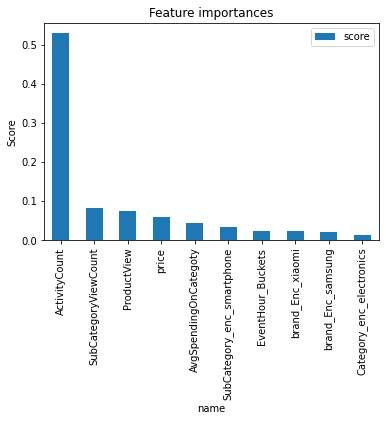

In [39]:
ax = RFfi.plot.bar(x = 'name',y='score')
ax.set_title("Feature importances")
ax.set_ylabel("Score")